In [1]:
base_dir = '/home/users/delon/aemulus_nu/'

In [2]:
import numpy as np
cosmos = {}

tier1_fname = base_dir+'tier1_cosmos.txt'
f = open(tier1_fname, 'r')
columns = [col[:-1] for col in f.readline().strip().split()[1:]]
print(columns)
i = 0
for line in f:
    box_name = 'Box%d_1400'%(i)
    assert(len(line.split()) == len(columns))
    cosmos[box_name] = dict(zip(columns, np.array(line.split(), dtype=np.float64)))
    i+=1
f.close()


tier2_fname = base_dir+'tier2_cosmos.txt'
f = open(tier2_fname, 'r')
columns = [col[:-1] for col in f.readline().strip().split()[1:]]
print(columns)
i = 0
for line in f:
    box_name = 'Box_n50_%d_1400'%(i)
    assert(len(line.split()) == len(columns))
    cosmos[box_name] = dict(zip(columns, np.array(line.split(), dtype=np.float64)))
    i+=1
f.close()

['As', 'ns', 'H0', 'w0', 'ombh2', 'omch2', 'nu_mass_ev', 'sigma']
['As', 'ns', 'H0', 'w0', 'ombh2', 'omch2', 'nu_mass_ev', 'sigma']


In [3]:
from utils import *
import numpy as np

In [4]:
from tqdm import tqdm, trange
from classy import Class
import pickle

pbar = tqdm(cosmos)

for key in pbar:
    if('63' in key):
        continue
#     if(key != 'Box_n50_0_1400' and key != 'Box0_1400'):
#         continue
    pbar.set_description(key)

    cosmo = cosmos[key]
    h = cosmo['H0']/100
    cosmo_dict = {
        'h': h,
        'Omega_b': cosmo['ombh2'] / h**2,
        'Omega_cdm': cosmo['omch2'] / h**2,
        'N_ur': 0.00641,
        'N_ncdm': 1,
        'output': 'mPk mTk',
        'z_pk': '0.0,99',
        'P_k_max_h/Mpc': 20.,
        'm_ncdm': cosmo['nu_mass_ev']/3,
        'deg_ncdm': 3,
        'T_cmb': 2.7255,
        'A_s': cosmo['As'] * 10**-9,
        'n_s': cosmo['ns'],
        'Omega_Lambda': 0.0,
        'w0_fld': cosmo['w0'],
        'wa_fld': 0.0,
        'cs2_fld': 1.0,
        'fluid_equation_of_state': "CLP"
    }
    pkclass = Class()
    pkclass.set(cosmo_dict)
    pkclass.compute()
    
    curr_run_fname = '/oak/stanford/orgs/kipac/aemulus/aemulus_nu/%s/'%(key)
    rockstar_dir = curr_run_fname+'output/rockstar/'

    f = open(rockstar_dir+'savelist.txt', 'r')
    savelist = f.read().split()
    f.close()

    N_snapshots = len(savelist)
    a = []
    for i in range(N_snapshots):
        f = open(rockstar_dir+'out_%d.list'%(i), 'r')

        for line in f:
            if('#a' in line):
                a+= [eval(line.split()[2])]
                break


    zs = [scaleToRedshift(a_curr) for a_curr in a]

    Pkz = {}
    for z in  zs:
        kt = np.logspace(-5, 1, 100) #units of 1 / Mpc

        pk_m_lin = np.array(
            [
                pkclass.pk_lin(ki, np.array([z])) #units of Mpc^3
                for ki in kt 
            ]
        )
        from scipy.interpolate import interp1d
        #given k in units of h/Mpc gives Pk in units of Mpc^3/h^3 
        Pk = interp1d(kt/h, pk_m_lin*h**3, kind='linear', bounds_error=False, fill_value=0.)

        Pkz[z] = Pk    
        class_sigma8 = pkclass.sigma(8, z, h_units=True)
        my_sigma8 = np.sqrt(sigma2(Pk, 8))
        assert(np.abs(class_sigma8-my_sigma8)<0.01*class_sigma8)
#         plt.plot(kt, Pk(kt))
#         plt.xscale('log')
#         plt.yscale('log')
#         plt.show()
    
    Pk_fname = '/oak/stanford/orgs/kipac/users/delon/aemulusnu_massfunction/'+key+'_Pk.pkl'
    Pk_f = open(Pk_fname, 'wb')
    pickle.dump(Pkz, Pk_f)
    Pk_f.close()


Box0_1400:   0%|          | 0/150 [00:00<?, ?it/s]/home/users/delon/aemulusnu_massfunction/utils.py:65: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  res, err = quad(dσ2dk, 0, 20 / R)
Box_n50_49_1400: 100%|██████████| 150/150 [04:07<00:00,  1.65s/it]


In [5]:
pkclass.sigma(8, z, h_units=True)

0.8050700417367127

In [6]:
np.sqrt(sigma2(Pk, 8))

0.8076689062131196

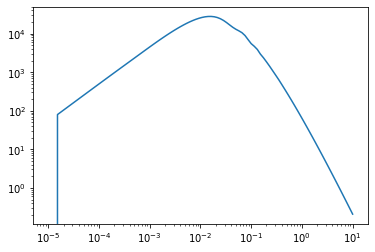

In [7]:
plt.plot(kt, Pk(kt))
plt.xscale('log')
plt.yscale('log')